# Valence class classification

In [1]:
#!pip install AutoViz
#!pip install xlrd
!pip install imbalanced-learn

In [77]:
# Loading all the modules that I will use in this notebook
from itertools import product


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from autoviz.AutoViz_Class import AutoViz_Class

import imblearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import cudf, cuml
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.multiclass import MulticlassClassifier
from cuml.multiclass import OneVsRestClassifier

### 1. Load Data

In [4]:
# Loading the train, test and validation data(datasets) + looking the first 5 rows of the train dataset as confirmation that the data is loaded
train = pd.read_csv('../input/classification/classification/train/videos_emg_features_05_01_train.csv')
validation = pd.read_csv('../input/classification/classification/validation/videos_emg_features_05_01_validation.csv')
test = pd.read_csv('../input/classification/classification/test/videos_emg_features_05_01_test.csv')
train.head()

,Subject,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,...,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,video,arousal,valence,class
0,Subject 26,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,...,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07,GroupA\01,4.0,5.0,neutral
1,Subject 26,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,...,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07,GroupA\01,4.0,5.0,neutral
2,Subject 26,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,...,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07,GroupA\01,4.0,5.0,neutral
3,Subject 26,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,...,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07,GroupA\01,4.0,5.0,neutral
4,Subject 26,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,...,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07,GroupA\01,4.0,5.0,neutral


### 2. Basic Data Exploration

In [5]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136900 entries, 0 to 136899
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 253.8+ MB


In [6]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the validation dataset
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34022 entries, 0 to 34021
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 63.1+ MB


In [7]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30791 entries, 0 to 30790
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 57.1+ MB


In [8]:
# The names of the columns(features) of the train dataset(basically they are same for the train, validation and test datasets)
print(train.columns.to_list())

['Subject', '0_iav', '0_aac', '0_ar1', '0_ar2', '0_ar3', '0_ar4', '0_cc1', '0_cc2', '0_cc3', '0_cc4', '0_dasdv', '0_kurt', '0_log', '0_mav1', '0_mav2', '0_mav', '0_mhw', '0_mtw', '0_rms', '0_skew', '0_ssi', '0_tm', '0_var', '0_v_order', '0_wl', '0_mnf', '0_mdf', '0_pkf', '0_mnp', '0_ttp', '0_vcf', '0_psr', '0_ohm', '0_maxx', '1_iav', '1_aac', '1_ar1', '1_ar2', '1_ar3', '1_ar4', '1_cc1', '1_cc2', '1_cc3', '1_cc4', '1_dasdv', '1_kurt', '1_log', '1_mav1', '1_mav2', '1_mav', '1_mhw', '1_mtw', '1_rms', '1_skew', '1_ssi', '1_tm', '1_var', '1_v_order', '1_wl', '1_mnf', '1_mdf', '1_pkf', '1_mnp', '1_ttp', '1_vcf', '1_psr', '1_ohm', '1_maxx', '2_iav', '2_aac', '2_ar1', '2_ar2', '2_ar3', '2_ar4', '2_cc1', '2_cc2', '2_cc3', '2_cc4', '2_dasdv', '2_kurt', '2_log', '2_mav1', '2_mav2', '2_mav', '2_mhw', '2_mtw', '2_rms', '2_skew', '2_ssi', '2_tm', '2_var', '2_v_order', '2_wl', '2_mnf', '2_mdf', '2_pkf', '2_mnp', '2_ttp', '2_vcf', '2_psr', '2_ohm', '2_maxx', '3_iav', '3_aac', '3_ar1', '3_ar2', '3_ar3'

In [9]:
# The datatypes of each feature
print(train.dtypes.to_list())

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

In [10]:
# All the features which datatype is object(string)
print(train.select_dtypes(include=['object']).columns.to_list())

['Subject', 'video', 'class']


In [11]:
# The shape of the train, validation, test datasets(number of rows + colums)
print(train.shape)
print(validation.shape)
print(test.shape)

(136900, 243)
(34022, 243)
(30791, 243)


In [12]:
# Some basic statistics about the train dataset(for every feature)
train.describe()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,arousal,valence
count,136900.000000,1.369000e+05,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,...,136900.000000,136900.000000,1.369000e+05,1.369000e+05,136900.000000,136900.000000,136900.000000,1.369000e+05,136900.000000,136900.000000
mean,0.000962,2.011216e-06,-0.271099,0.044827,-0.468986,0.479032,0.271099,-0.052796,0.424350,-0.796404,...,797.182504,643.969365,8.603373e-15,2.159447e-12,226518.552672,226518.552672,1.124445,3.803549e-07,4.027392,4.858254
std,0.001095,2.205904e-06,0.055585,0.129302,0.162632,0.278002,0.055585,0.148736,0.090637,0.497404,...,167.655869,200.395509,6.309540e-14,1.583695e-11,73350.152853,73350.152853,0.021839,5.015984e-07,2.387450,2.051504
min,0.000079,5.298191e-22,-0.646185,-1.010335,-1.278402,-0.188837,-0.770062,-0.843842,-0.528635,-4.527535,...,30.720000,0.000000,4.815219e-47,1.208620e-44,10376.386606,10376.386606,1.000986,1.018363e-07,1.000000,1.000000
25%,0.000457,1.126037e-06,-0.306377,-0.046400,-0.548088,0.259662,0.238753,-0.136083,0.363811,-1.185796,...,665.600000,522.240000,5.877735e-16,1.475311e-13,160450.658424,160450.658424,1.109027,1.668098e-07,2.000000,3.000000
50%,0.000647,1.410171e-06,-0.273208,0.025893,-0.429214,0.482127,0.273208,-0.029235,0.426405,-0.750072,...,747.520000,604.160000,1.228682e-15,3.083992e-13,237748.170152,237748.170152,1.124208,2.363802e-07,4.000000,5.000000
75%,0.001081,2.093361e-06,-0.238753,0.118917,-0.360350,0.700024,0.306377,0.052279,0.487836,-0.401789,...,911.360000,706.560000,4.271765e-15,1.072213e-12,287975.965854,287975.965854,1.138832,4.407158e-07,6.000000,6.000000
max,0.034699,7.104418e-05,0.770062,0.748818,0.935470,1.840554,0.646185,0.694043,0.973251,0.359982,...,2549.760000,2560.000000,2.593379e-12,6.509381e-10,882278.729335,882278.729335,1.750818,1.194507e-05,9.000000,9.000000


In [13]:
# Looking if there are any NaN/Null values in the train dataset
train.isna().sum().sum()

0

In [14]:
# Looking if there are any NaN/Null values in the validation dataset
validation.isna().sum().sum()

0

In [15]:
# Looking if there are any NaN/Null values in the test dataset
test.isna().sum().sum()

0

### 3. EDA, Visualization

In [16]:
# Getting the unique values of the valence column from the train dataset
valences=train["valence"]
unique_valences, num_examples_per_valence = np.unique(valences, return_counts = True)
unique_valences

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [17]:
# Getting the unique values of the class column from the train dataset
classes=train["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [18]:
# Calculating the percentages of how many entries are negative, neutral and positive(from the class)
negative_perc=num_examples_per_class[0]/(num_examples_per_class.sum())*100
positive_perc=num_examples_per_class[2]/(num_examples_per_class.sum())*100
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

53.21183345507669

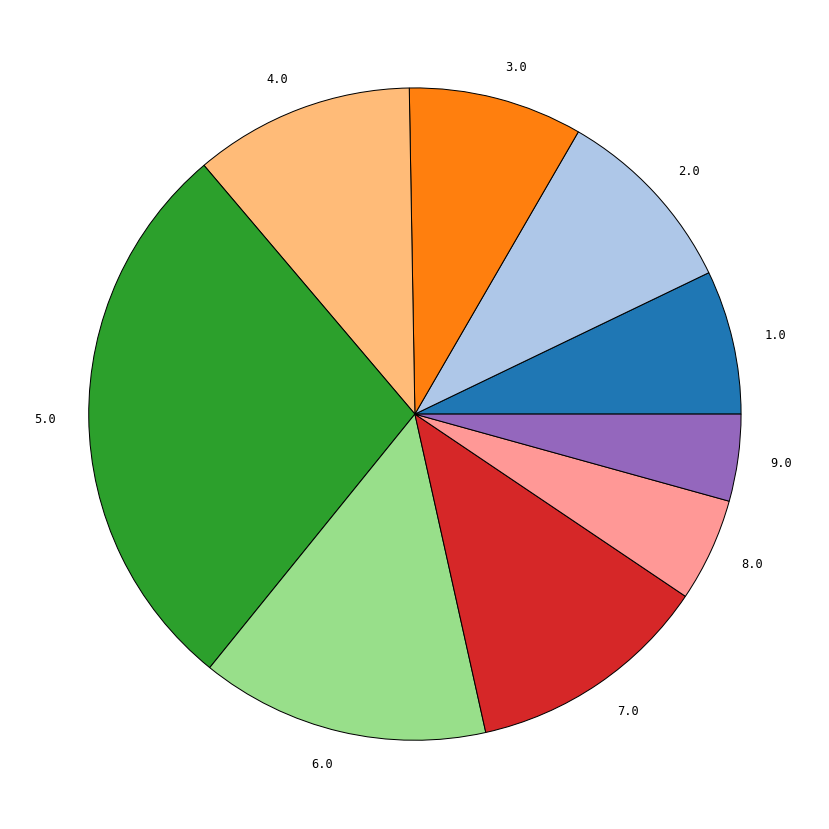

In [19]:
# Plotting the distribution of the valence per entries
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))

# define the color palette which we will use
cmap = plt.get_cmap("tab20")
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_valence))]

# use the pie chart function in the pyplot module to visualize the activity distributions
ax.pie(x = num_examples_per_valence, 
       colors = sampled_colors,
       labels = unique_valences, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

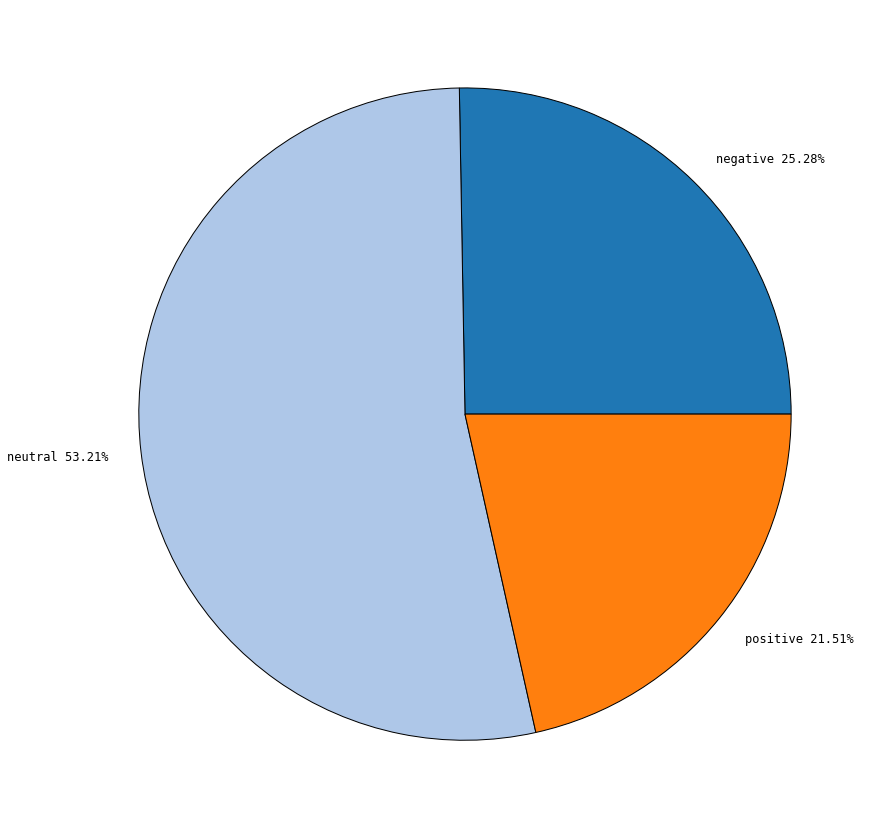

In [20]:
# Plotting the distribution of classes per entry
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
# define the color palette which we will use
cmap = plt.get_cmap("tab20")
neg= "{:.2f}".format(negative_perc)
neut= "{:.2f}".format(neutral_perc)
pos = "{:.2f}".format(positive_perc)
my_labels=['','','']
my_labels[0]=unique_classes[0]+" "+str(neg)+"%"
my_labels[1]=unique_classes[1]+" "+str(neut)+"%"
my_labels[2]=unique_classes[2]+" "+str(pos)+"%"
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_class))]
ax.pie(x = num_examples_per_class, 
       colors = sampled_colors,
       labels = my_labels, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

In [ ]:
# Auto visualization of all the features of the dataset
#AV = AutoViz_Class()
#viz = AV.AutoViz('../input/classification/classification/train/videos_emg_features_05_01_train.csv')

### 4. Data Preprocessing + Data Split

In [22]:
# From train dataset remove every second row with neutral class to basically undersample it
train_no_neutral = train[train["class"] != "neutral"]
train_neutral = train[train["class"] == "neutral"]
train_neutral = train_neutral.iloc[::2,:]
train_undersample = pd.concat([train_no_neutral, train_neutral])

In [23]:
# Getting the unique values of the class column from the train dataset
classes=train_undersample["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [24]:
# The neutral class in percentage
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

36.25108233725131

In [25]:
# From the train dataset dropping all the columns(info) about the subject, video, arousal
train = train.drop(['Subject' ,'video', 'arousal'], axis = 1)
train.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,-0.966924,...,604.16,491.52,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07,5.0,neutral
1,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,-0.908324,...,634.88,583.68,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07,5.0,neutral
2,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,-0.840275,...,593.92,583.68,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07,5.0,neutral
3,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,-0.811550,...,655.36,583.68,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07,5.0,neutral
4,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,-0.825662,...,665.60,573.44,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07,5.0,neutral


In [26]:
# From the train dataset(undersampled) dropping all the columns(info) about the subject, video, arousal
train_undersample = train_undersample.drop(['Subject' ,'video', 'arousal'], axis = 1)
train_undersample

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
1425,0.000457,0.000001,-0.304558,0.033892,-0.436900,0.288169,0.304558,-0.039053,0.419838,-0.469645,...,696.32,614.40,9.611239e-16,2.412421e-13,257084.754572,257084.754572,1.155056,2.074795e-07,8.0,positive
1426,0.000445,0.000001,-0.282495,0.055604,-0.420825,0.315732,0.282495,-0.063458,0.394120,-0.502387,...,686.08,614.40,1.011924e-15,2.539930e-13,246597.071245,246597.071245,1.153380,2.246294e-07,8.0,positive
1427,0.000456,0.000001,-0.291795,0.102708,-0.417988,0.347847,0.291795,-0.117692,0.368794,-0.540273,...,706.56,460.80,9.747226e-16,2.446554e-13,257730.115240,257730.115240,1.154494,2.311558e-07,8.0,positive
1428,0.000456,0.000001,-0.285606,0.076205,-0.403359,0.349487,0.285606,-0.087088,0.368231,-0.542524,...,727.04,460.80,9.342239e-16,2.344902e-13,262742.028706,262742.028706,1.153435,2.230335e-07,8.0,positive
1429,0.000449,0.000001,-0.286187,0.083875,-0.415130,0.346961,0.286187,-0.095877,0.375329,-0.542297,...,778.24,532.48,8.411788e-16,2.111359e-13,278349.961286,278349.961286,1.152133,2.159123e-07,8.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134023,0.000638,0.000001,-0.270072,0.000822,-0.366114,0.590294,0.270072,-0.000933,0.365772,-0.914164,...,604.16,542.72,1.117570e-15,2.805101e-13,231600.488240,231600.488240,1.169469,2.245912e-07,6.0,neutral
134025,0.000620,0.000001,-0.259046,0.028174,-0.433347,0.553584,0.259046,-0.031824,0.419556,-0.901973,...,655.36,512.00,8.800722e-16,2.208981e-13,249477.991089,249477.991089,1.167373,2.098825e-07,6.0,neutral
134027,0.000603,0.000001,-0.255483,0.055379,-0.477883,0.590194,0.255483,-0.062454,0.448037,-0.986837,...,686.08,696.32,8.075793e-16,2.027024e-13,248819.677564,248819.677564,1.153330,2.107168e-07,6.0,neutral
134029,0.000575,0.000001,-0.246280,0.026292,-0.454068,0.592796,0.246280,-0.029530,0.440659,-0.984628,...,675.84,450.56,8.358221e-16,2.097914e-13,269365.861708,269365.861708,1.160668,1.692427e-07,6.0,neutral


In [27]:
# From the validation dataset dropping all the columns(info) about the subject, video, arousal
validation = validation.drop(['Subject' ,'video', 'arousal'], axis = 1)
validation.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07,8.0,positive
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07,8.0,positive
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07,8.0,positive
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07,8.0,positive
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07,8.0,positive


In [28]:
# From the test dataset dropping all the columns(info) about the subject, video, arousal
test = test.drop(['Subject' ,'video', 'arousal'], axis = 1)
test.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000477,0.000001,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07,4.0,neutral
1,0.000465,0.000001,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07,4.0,neutral
2,0.000429,0.000001,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07,4.0,neutral
3,0.000427,0.000001,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07,4.0,neutral
4,0.000417,0.000001,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07,4.0,neutral


In [29]:
# The train data is all the columns except the last 2 columns which are the target + class 
X_train = train.iloc[:,:-2]
X_train

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,-0.966924,...,-4.712230e-06,777.582881,604.16,491.52,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07
1,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,-0.908324,...,-2.219070e-06,795.819529,634.88,583.68,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07
2,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,-0.840275,...,4.887581e-06,798.745054,593.92,583.68,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07
3,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,-0.811550,...,7.152557e-07,804.709039,655.36,583.68,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07
4,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,-0.825662,...,5.165736e-07,803.127950,665.60,573.44,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136895,0.000516,0.000001,-0.362316,0.014572,-0.336977,0.353298,0.362316,-0.017212,0.331177,-0.528804,...,-1.788162e-07,970.297467,870.40,532.48,1.159675e-15,2.910785e-13,236097.357271,236097.357271,1.118380,2.229397e-07
136896,0.000527,0.000001,-0.347752,0.014216,-0.346542,0.401977,0.347752,-0.016688,0.340758,-0.607442,...,-1.792161e-06,956.605358,819.20,624.64,1.128472e-15,2.832464e-13,251853.292594,251853.292594,1.129257,2.375530e-07
136897,0.000532,0.000001,-0.389285,0.031756,-0.374169,0.393635,0.389285,-0.037937,0.359974,-0.606184,...,-2.642475e-06,936.343407,788.48,532.48,1.201034e-15,3.014595e-13,250166.091238,250166.091238,1.133727,2.462810e-07
136898,0.000525,0.000001,-0.411930,0.052148,-0.392349,0.395622,0.411930,-0.062889,0.367674,-0.613813,...,-4.533975e-06,938.880738,737.28,450.56,1.143954e-15,2.871324e-13,270763.326829,270763.326829,1.143312,2.026677e-07


In [30]:
# The target for the train data is  before the last column
y_train = train.iloc[:,-2]
y_train

0         5.0
1         5.0
2         5.0
3         5.0
4         5.0
         ... 
136895    9.0
136896    9.0
136897    9.0
136898    9.0
136899    9.0
Name: valence, Length: 136900, dtype: float64

In [31]:
# The class for the train data is the last column
pred_train = train.iloc[:,-1]
pred_train

0          neutral
1          neutral
2          neutral
3          neutral
4          neutral
            ...   
136895    positive
136896    positive
136897    positive
136898    positive
136899    positive
Name: class, Length: 136900, dtype: object

In [32]:
# The validation data is all the columns except the last 2 columns which are the target + class 
X_validation = validation.iloc[:,:-2]
X_validation

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,-2.519672e-06,1089.883827,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,-2.524838e-06,1012.890525,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,2.019187e-06,1043.770519,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,2.324842e-06,1107.718475,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,9.845659e-08,1105.282820,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34017,0.000723,0.000002,-0.319766,0.026889,-0.560346,0.317735,0.319766,-0.031188,0.542870,-0.576469,...,-4.588549e-06,1067.403952,1013.76,798.72,1.587567e-15,3.984793e-13,230911.959153,230911.959153,1.096663,2.798654e-07
34018,0.000837,0.000002,-0.313002,0.042930,-0.481843,0.370989,0.313002,-0.049648,0.457921,-0.625814,...,1.723964e-07,1104.600618,1024.00,686.08,1.489861e-15,3.739552e-13,240956.652418,240956.652418,1.094295,2.749026e-07
34019,0.000908,0.000002,-0.148813,-0.103651,-0.242217,0.311284,0.148813,0.111363,0.269191,-0.436976,...,5.352461e-06,1115.519141,1013.76,849.92,1.428781e-15,3.586240e-13,230218.115760,230218.115760,1.088580,2.779582e-07
34020,0.000872,0.000002,-0.155239,-0.100510,-0.232381,0.321751,0.155239,0.108311,0.257551,-0.446052,...,8.625256e-07,1103.095271,1013.76,849.92,1.205931e-15,3.026887e-13,251503.807192,251503.807192,1.098494,2.616199e-07


In [33]:
# The target for the validation data is  before the last column
y_validation = validation.iloc[:,-2]
y_validation

0        8.0
1        8.0
2        8.0
3        8.0
4        8.0
        ... 
34017    4.0
34018    4.0
34019    4.0
34020    4.0
34021    4.0
Name: valence, Length: 34022, dtype: float64

In [34]:
# The class for the validation data is the last column
pred_validation = validation.iloc[:,-1]
pred_validation

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
34017     neutral
34018     neutral
34019     neutral
34020     neutral
34021     neutral
Name: class, Length: 34022, dtype: object

In [35]:
# The test data is all the columns except the last 2 columns which are the target + class 
X_test = test.iloc[:,:-2]
X_test

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000477,1.211073e-06,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,2.924024e-06,1106.773055,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07
1,0.000465,1.164340e-06,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,-6.643470e-07,1127.921677,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07
2,0.000429,1.100598e-06,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,2.531475e-06,1119.944004,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07
3,0.000427,1.070966e-06,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,2.197901e-06,1148.386357,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07
4,0.000417,1.051405e-06,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1.938682e-06,1136.543983,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30786,0.000378,9.782695e-07,-0.200098,-0.094488,-0.394690,0.114856,0.200098,0.103941,0.435715,-0.189922,...,3.077239e-07,1109.602126,1003.52,512.00,3.801815e-16,9.542556e-14,293369.805483,293369.805483,1.112779,1.265193e-07
30787,0.000387,9.882117e-07,-0.176761,-0.052263,-0.418838,0.167116,0.176761,0.056882,0.442662,-0.278080,...,3.008856e-06,1095.440043,1003.52,512.00,4.053952e-16,1.017542e-13,297765.497411,297765.497411,1.117202,1.223218e-07
30788,0.000415,1.043870e-06,-0.173375,-0.044805,-0.490658,0.187141,0.173375,0.048689,0.514548,-0.331580,...,-3.388402e-07,1043.734078,911.36,522.24,4.317347e-16,1.083654e-13,284341.209554,284341.209554,1.122948,1.411798e-07
30789,0.000401,1.021297e-06,-0.189029,-0.056490,-0.484879,0.185424,0.189029,0.061829,0.514858,-0.328624,...,-1.996970e-06,1043.507844,911.36,675.84,4.404827e-16,1.105612e-13,300924.020520,300924.020520,1.129758,1.484544e-07


In [36]:
# The target for the test data is  before the last column
y_test = test.iloc[:,-2]
y_test

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
30786    5.0
30787    5.0
30788    5.0
30789    5.0
30790    5.0
Name: valence, Length: 30791, dtype: float64

In [37]:
# The class for the test data is the last column
pred_test = test.iloc[:,-1]
pred_test

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
30786    neutral
30787    neutral
30788    neutral
30789    neutral
30790    neutral
Name: class, Length: 30791, dtype: object

In [38]:
# Scaling all the data between -1 and 1 for the train, validation and test
stardard_scaler = StandardScaler()
X_train_st = stardard_scaler.fit_transform(X_train)
X_validation_st = stardard_scaler.transform(X_validation)
X_test_st = stardard_scaler.transform(X_test)

In [39]:
minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_validation_mm = minmax_scaler.transform(X_validation)
X_test_mm = minmax_scaler.transform(X_test)

In [40]:
# Encoding the classes 
encoder = LabelEncoder()
pred_train = encoder.fit_transform(pred_train)
pred_validation = encoder.transform(pred_validation)
pred_test = encoder.transform(pred_test)

In [41]:
# What are the encoded classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

### 5. Training models

In [42]:
# Defining a dictionary which will be used for mapping the results of the regression
dict = {1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

In [43]:
def con_matrix(y_true, pred):
    cf = confusion_matrix(y_true, pred)
    sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [44]:
# Scoring the quasi classification of the model
def score_classification(y_true, pred):
    pred = np.array(list(map(lambda x: dict[x], pred)))
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [45]:
# Scoring the regression model
def score_regression(y_validation, pred):
    print(f'Mean absolute error:  {mean_absolute_error(y_validation, pred)}')
    print("--------------------")
    print(f'Mean squared error: {mean_squared_error(y_validation, pred)}')
    print("--------------------")
    print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_validation, pred))}')
    print("--------------------")
    print(f'R2 score: {r2_score(y_validation,pred)}')
    print("--------------------")

In [46]:
# Score the pure classification model
def score_pure_classification(y_true, pred):
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [47]:
# Transforming the regression data
def transformData(pred):
    pred = np.floor(pred)
    pred[pred > 9] = 9
    pred[pred <= 0] = 1
    return pred

## SVC ONE VS REST

### Standard Scaler Data

#### KERNEL-RBF

In [49]:
svc = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc.fit(X_train_st, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.21      0.30      0.24      5552
           1       0.75      0.59      0.66     23230
           2       0.25      0.39      0.31      5240

    accuracy                           0.51     34022
   macro avg       0.40      0.42      0.40     34022
weighted avg       0.58      0.51      0.54     34022

--------------------
The accuracy of the model is: 0.507642113926283
--------------------
The f1-macro score for the model is: 0.4028307584460648
--------------------


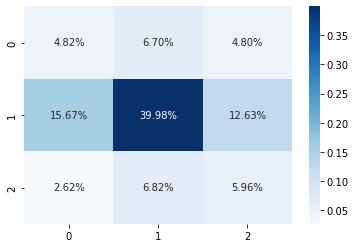

In [50]:
pred = svc.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.24      0.23      0.24      7117
           1       0.57      0.44      0.50     19330
           2       0.22      0.44      0.29      4344

    accuracy                           0.39     30791
   macro avg       0.34      0.37      0.34     30791
weighted avg       0.45      0.39      0.41     30791

--------------------
The accuracy of the model is: 0.3946607774999188
--------------------
The f1-macro score for the model is: 0.34173787872260536
--------------------


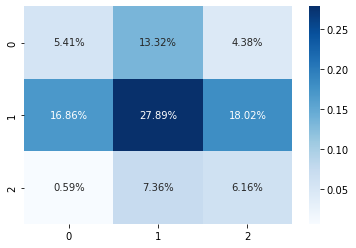

In [51]:
pred = svc.predict(X_test_st)
score_pure_classification(pred_test, pred)

#### KERNEL-LINEAR

In [54]:
svc = SVC(kernel = 'linear', multiclass_strategy= 'ovr')
svc.fit(X_train_st, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.43      0.26      0.32      5552
           1       0.76      0.79      0.78     23230
           2       0.31      0.39      0.34      5240

    accuracy                           0.64     34022
   macro avg       0.50      0.48      0.48     34022
weighted avg       0.64      0.64      0.64     34022

--------------------
The accuracy of the model is: 0.6439068837810829
--------------------
The f1-macro score for the model is: 0.48170854450158646
--------------------


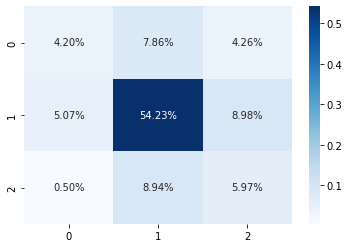

In [55]:
pred = svc.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.03      0.01      0.02      7117
           1       0.61      0.76      0.68     19330
           2       0.26      0.27      0.26      4344

    accuracy                           0.52     30791
   macro avg       0.30      0.35      0.32     30791
weighted avg       0.43      0.52      0.47     30791

--------------------
The accuracy of the model is: 0.5176512617323243
--------------------
The f1-macro score for the model is: 0.31874987855109027
--------------------


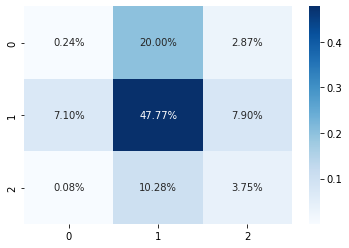

In [56]:
pred = svc.predict(X_test_st)
score_pure_classification(pred_test, pred)

#### KERNEL-POLY

In [57]:
svc = SVC(kernel = 'poly', multiclass_strategy= 'ovr')
svc.fit(X_train_st, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.30      0.24      0.27      5552
           1       0.75      0.78      0.77     23230
           2       0.34      0.36      0.35      5240

    accuracy                           0.63     34022
   macro avg       0.47      0.46      0.46     34022
weighted avg       0.62      0.63      0.62     34022

--------------------
The accuracy of the model is: 0.6287696196578685
--------------------
The f1-macro score for the model is: 0.46343463989412575
--------------------


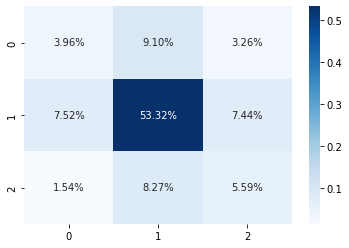

In [58]:
pred = svc.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.12      0.07      0.09      7117
           1       0.56      0.53      0.55     19330
           2       0.16      0.30      0.21      4344

    accuracy                           0.39     30791
   macro avg       0.28      0.30      0.28     30791
weighted avg       0.40      0.39      0.39     30791

--------------------
The accuracy of the model is: 0.3942385762073333
--------------------
The f1-macro score for the model is: 0.28247749246832793
--------------------


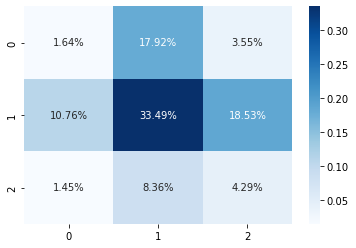

In [59]:
pred = svc.predict(X_test_st)
score_pure_classification(pred_test, pred)

#### KERNEL-SIGMOID

In [62]:
svc = SVC(kernel = 'sigmoid', multiclass_strategy= 'ovr')
svc.fit(X_train_st, pred_train)

Exception ignored in: <bound method SVMBase.__del__ of SVC()>
Traceback (most recent call last):
  File "cuml/svm/svm_base.pyx", line 250, in cuml.svm.svm_base.SVMBase.__del__
  File "cuml/svm/svm_base.pyx", line 257, in cuml.svm.svm_base.SVMBase._dealloc
  File "cuml/common/base.pyx", line 270, in cuml.common.base.Base.__getattr__
AttributeError: 


SVC()

              precision    recall  f1-score   support

           0       0.30      0.22      0.25      5552
           1       0.68      0.41      0.52     23230
           2       0.16      0.49      0.24      5240

    accuracy                           0.39     34022
   macro avg       0.38      0.37      0.34     34022
weighted avg       0.54      0.39      0.43     34022

--------------------
The accuracy of the model is: 0.3936276526953148
--------------------
The f1-macro score for the model is: 0.33699469334453686
--------------------


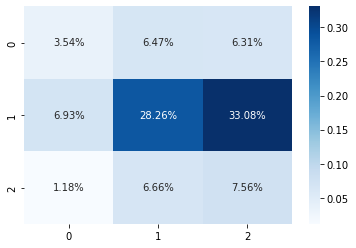

In [63]:
pred = svc.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.38      0.04      0.07      7117
           1       0.67      0.65      0.66     19330
           2       0.19      0.50      0.27      4344

    accuracy                           0.48     30791
   macro avg       0.41      0.39      0.34     30791
weighted avg       0.54      0.48      0.47     30791

--------------------
The accuracy of the model is: 0.48494690006820174
--------------------
The f1-macro score for the model is: 0.335396504038963
--------------------


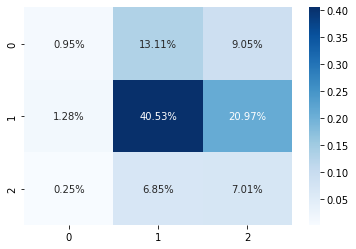

In [64]:
pred = svc.predict(X_test_st)
score_pure_classification(pred_test, pred)

### MinMax Scaler Data

#### KERNEL-RBF

In [65]:
svc = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc.fit(X_train_mm, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.55      0.32      0.41      5552
           1       0.77      0.79      0.78     23230
           2       0.31      0.42      0.36      5240

    accuracy                           0.66     34022
   macro avg       0.55      0.51      0.52     34022
weighted avg       0.67      0.66      0.66     34022

--------------------
The accuracy of the model is: 0.6579272235612251
--------------------
The f1-macro score for the model is: 0.5168517692821719
--------------------


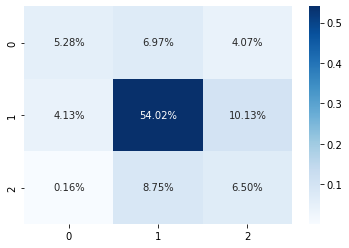

In [66]:
pred = svc.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.18      0.02      0.04      7117
           1       0.67      0.84      0.74     19330
           2       0.38      0.50      0.43      4344

    accuracy                           0.60     30791
   macro avg       0.41      0.45      0.40     30791
weighted avg       0.51      0.60      0.54     30791

--------------------
The accuracy of the model is: 0.6001104218765224
--------------------
The f1-macro score for the model is: 0.40329440782159476
--------------------


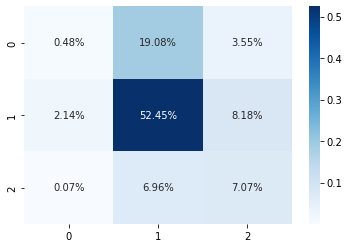

In [67]:
pred = svc.predict(X_test_mm)
score_pure_classification(pred_test, pred)

#### KERNEL-LINEAR

In [68]:
svc = SVC(kernel = 'linear', multiclass_strategy= 'ovr')
svc.fit(X_train_mm, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.52      0.16      0.25      5552
           1       0.76      0.83      0.79     23230
           2       0.30      0.41      0.35      5240

    accuracy                           0.65     34022
   macro avg       0.53      0.47      0.46     34022
weighted avg       0.65      0.65      0.63     34022

--------------------
The accuracy of the model is: 0.6531655987302334
--------------------
The f1-macro score for the model is: 0.4619219123648713
--------------------


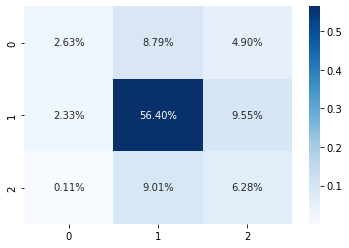

In [69]:
pred = svc.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.17      0.01      0.02      7117
           1       0.66      0.85      0.74     19330
           2       0.34      0.44      0.38      4344

    accuracy                           0.60     30791
   macro avg       0.39      0.43      0.38     30791
weighted avg       0.50      0.60      0.53     30791

--------------------
The accuracy of the model is: 0.5964405183332792
--------------------
The f1-macro score for the model is: 0.38196715934434033
--------------------


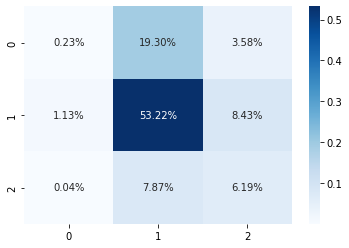

In [70]:
pred = svc.predict(X_test_mm)
score_pure_classification(pred_test, pred)

#### KERNEL-POLY

In [71]:
svc = SVC(kernel = 'poly', multiclass_strategy= 'ovr')
svc.fit(X_train_mm, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.44      0.33      0.38      5552
           1       0.77      0.75      0.76     23230
           2       0.31      0.43      0.36      5240

    accuracy                           0.63     34022
   macro avg       0.51      0.50      0.50     34022
weighted avg       0.65      0.63      0.64     34022

--------------------
The accuracy of the model is: 0.6313267885485863
--------------------
The f1-macro score for the model is: 0.49939236650902624
--------------------


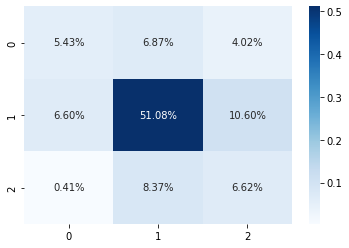

In [72]:
pred = svc.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.20      0.04      0.07      7117
           1       0.67      0.82      0.74     19330
           2       0.38      0.51      0.44      4344

    accuracy                           0.59     30791
   macro avg       0.42      0.46      0.41     30791
weighted avg       0.52      0.59      0.54     30791

--------------------
The accuracy of the model is: 0.5932577701276347
--------------------
The f1-macro score for the model is: 0.4125655077231902
--------------------


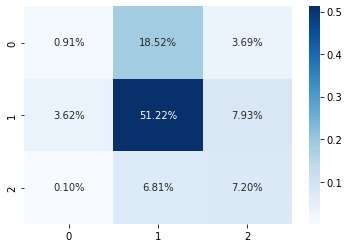

In [73]:
pred = svc.predict(X_test_mm)
score_pure_classification(pred_test, pred)

#### KERNEL-SIGMOID

In [74]:
svc = SVC(kernel = 'sigmoid', multiclass_strategy= 'ovr')
svc.fit(X_train_st, pred_train)

SVC()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5552
           1       0.00      0.00      0.00     23230
           2       0.15      1.00      0.27      5240

    accuracy                           0.15     34022
   macro avg       0.05      0.33      0.09     34022
weighted avg       0.02      0.15      0.04     34022

--------------------
The accuracy of the model is: 0.15401798836047265
--------------------
The f1-macro score for the model is: 0.08897492061874927
--------------------


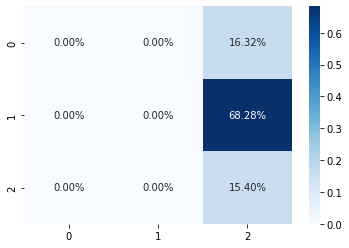

In [75]:
pred = svc.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7117
           1       0.00      0.00      0.00     19330
           2       0.14      1.00      0.25      4344

    accuracy                           0.14     30791
   macro avg       0.05      0.33      0.08     30791
weighted avg       0.02      0.14      0.03     30791

--------------------
The accuracy of the model is: 0.14108018576856873
--------------------
The f1-macro score for the model is: 0.08242493240358617
--------------------


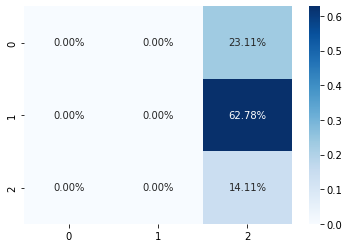

In [76]:
pred = svc.predict(X_test_mm)
score_pure_classification(pred_test, pred)

## MULTICLASS ONE VS REST

### Standard Scaler Data

In [78]:
mlt = MulticlassClassifier(LogisticRegression(), strategy='ovr')
mlt.fit(X_train_st, pred_train)

MulticlassClassifier()

              precision    recall  f1-score   support

           0       0.25      0.39      0.30      5552
           1       0.76      0.61      0.68     23230
           2       0.33      0.40      0.36      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5448239374522368
--------------------
The f1-macro score for the model is: 0.4472650107035521
--------------------


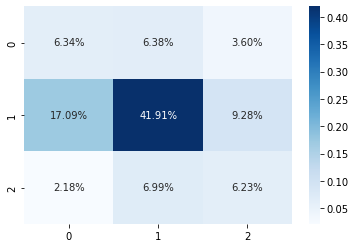

In [79]:
pred = mlt.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.11      0.07      0.08      7117
           1       0.59      0.62      0.61     19330
           2       0.27      0.36      0.31      4344

    accuracy                           0.46     30791
   macro avg       0.32      0.35      0.33     30791
weighted avg       0.44      0.46      0.44     30791

--------------------
The accuracy of the model is: 0.45815335650027605
--------------------
The f1-macro score for the model is: 0.33282242630659187
--------------------


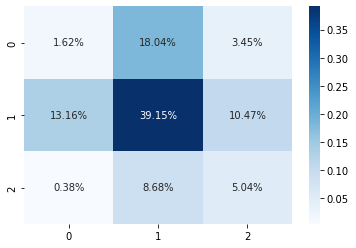

In [80]:
pred = mlt.predict(X_test_st)
score_pure_classification(pred_test, pred)

In [81]:
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train_st, pred_train)

OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.25      0.39      0.30      5552
           1       0.76      0.61      0.68     23230
           2       0.33      0.40      0.36      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5447063664687555
--------------------
The f1-macro score for the model is: 0.44725204560990783
--------------------


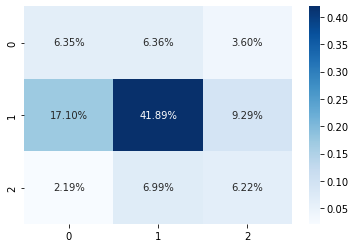

In [82]:
pred = ovr.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.11      0.07      0.09      7117
           1       0.60      0.62      0.61     19330
           2       0.27      0.36      0.31      4344

    accuracy                           0.46     30791
   macro avg       0.32      0.35      0.33     30791
weighted avg       0.44      0.46      0.45     30791

--------------------
The accuracy of the model is: 0.4591276671754734
--------------------
The f1-macro score for the model is: 0.33374704753143036
--------------------


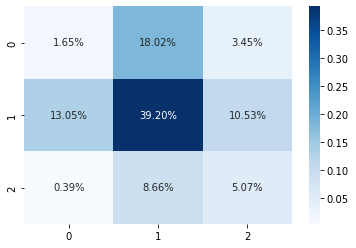

In [83]:
pred = ovr.predict(X_test_st)
score_pure_classification(pred_test, pred)

### MinMax Scaler Data

In [84]:
mlt = MulticlassClassifier(LogisticRegression(), strategy='ovr')
mlt.fit(X_train_mm, pred_train)

MulticlassClassifier()

              precision    recall  f1-score   support

           0       0.29      0.39      0.34      5552
           1       0.77      0.64      0.70     23230
           2       0.32      0.45      0.38      5240

    accuracy                           0.57     34022
   macro avg       0.46      0.50      0.47     34022
weighted avg       0.63      0.57      0.59     34022

--------------------
The accuracy of the model is: 0.5720710128740227
--------------------
The f1-macro score for the model is: 0.47137074173248034
--------------------


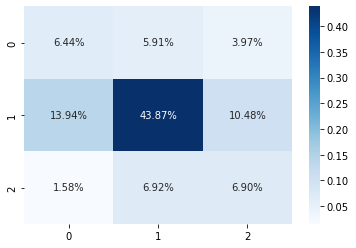

In [85]:
pred = mlt.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.29      0.06      0.10      7117
           1       0.66      0.76      0.71     19330
           2       0.29      0.46      0.36      4344

    accuracy                           0.56     30791
   macro avg       0.41      0.43      0.39     30791
weighted avg       0.52      0.56      0.52     30791

--------------------
The accuracy of the model is: 0.5589295573381833
--------------------
The f1-macro score for the model is: 0.3887604839258974
--------------------


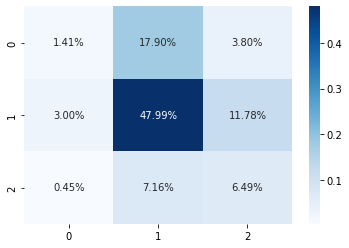

In [86]:
pred = mlt.predict(X_test_mm)
score_pure_classification(pred_test, pred)